# Initialization

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from datasets import Dataset
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, DataCollatorWithPadding,AutoModel
from torch.utils.data import WeightedRandomSampler, SubsetRandomSampler

from sklearn.utils import resample

from transformers import AutoModelForSequenceClassification

In [2]:
import os

# 1. Get the current working directory path
base_dir = os.path.abspath("")

# 2. Use os.path.join() to construct the file paths portably
# sentiment_file = os.path.join(base_dir, "dataset", "stock_data.csv")
stock_file = os.path.join(base_dir, "dataset", "stock_tweets.csv")

# Load the sentiment data from a CSV file
# sentiment_df = pd.read_csv(sentiment_file)
df = pd.read_csv("hf://datasets/StephanAkkerman/financial-tweets/financial_tweets.csv")
# Load the stock data from a CSV file
stock_df = pd.read_csv(stock_file)

In [3]:
# Keep only relevant columns
sentiment_df = df[["description", "sentiment"]].copy()

# Filter only valid sentiment labels
sentiment_df = sentiment_df[sentiment_df["sentiment"].isin(["Bullish", "Neutral", "Bearish"])]

# Map text labels to numeric values
label_map = {"Bearish": 0, "Neutral": 1, "Bullish": 2}
sentiment_df["sentiment"] = sentiment_df["sentiment"].map(label_map)
# print(stock_df.shape[0])
# print(sentiment_df.shape[0])

In [4]:
# Check the head using the familiar Pandas method
print(sentiment_df.columns)
print(stock_df.columns)

print(f"\nTotal elements in sentiment_df (via shape): {sentiment_df.shape[0]}")
print(f"Total elements in stock_df (via shape): {stock_df.shape[0]}")
# print("Sentiment Dataset Head:")
# print(sentiment_df.head())

# print("\nStock Dataset Info:")
# sentiment_df.info()

# print("Sentiment Dataset Head:")
# print(sentiment_df.head())

# print("\nStock Dataset Info:")
# sentiment_df.info()

Index(['description', 'sentiment'], dtype='object')
Index(['Date', 'Tweet', 'Stock Name', 'Company Name'], dtype='object')

Total elements in sentiment_df (via shape): 44426
Total elements in stock_df (via shape): 80793


In [5]:
def plot_distribution(df, label_column, title_prefix, color='skyblue'):
    """
    Plots and prints the count and ratio distribution for a categorical column.

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame to analyze.
    label_column : str
        The name of the column containing categorical labels (e.g., company, sentiment).
    title_prefix : str
        Prefix for the plot title (e.g., 'Company', 'Sentiment').
    color : str, optional
        Color for the bar plot (default is 'skyblue').

    Returns
    -------
    tuple
        (counts, ratios) as pandas Series objects.
    """
    # Count occurrences
    counts = df[label_column].value_counts()
    ratios = counts / counts.sum()

    # Plot distribution
    plt.figure(figsize=(10, 6))
    counts.plot(kind='bar', color=color)
    plt.title(f'{title_prefix} Distribution')
    plt.xlabel(title_prefix)
    plt.ylabel('Number of Records')
    plt.xticks(rotation=45 if title_prefix.lower() == 'company' else 0, ha='right')
    plt.tight_layout()
    plt.show()

    # Display results
    print(f"=== {title_prefix} Ratios ===")
    print(ratios)
    print(f"\n=== {title_prefix} Counts ===")
    print(counts)
    
    return counts, ratios

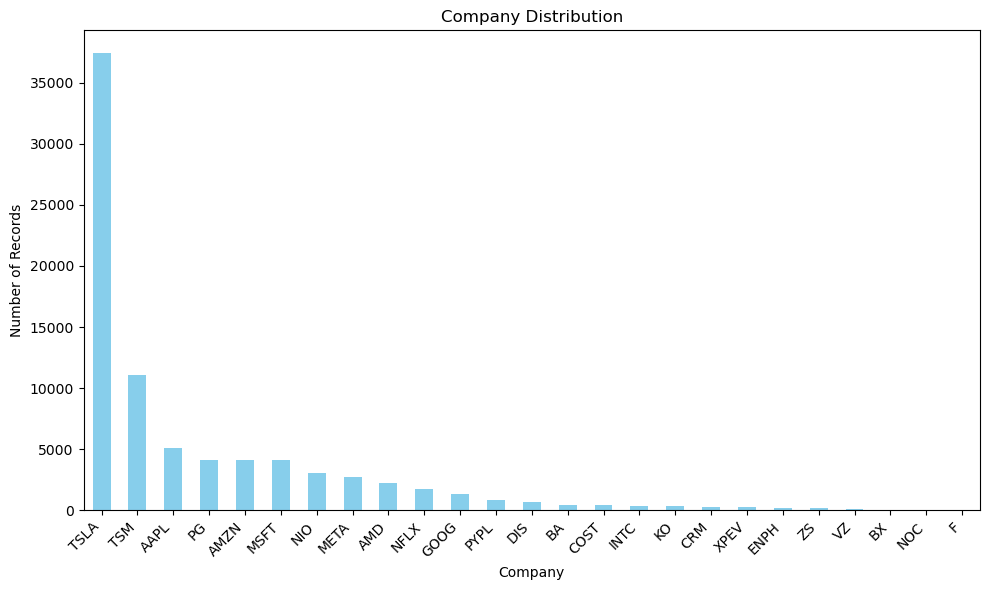

=== Company Ratios ===
Stock Name
TSLA    0.463184
TSM     0.136571
AAPL    0.062580
PG      0.050611
AMZN    0.050611
MSFT    0.050611
NIO     0.037392
META    0.034050
AMD     0.027564
NFLX    0.021376
GOOG    0.015979
PYPL    0.010434
DIS     0.007860
BA      0.004939
COST    0.004864
INTC    0.003899
KO      0.003837
CRM     0.002884
XPEV    0.002785
ENPH    0.002673
ZS      0.002389
VZ      0.001522
BX      0.000619
NOC     0.000384
F       0.000384
Name: count, dtype: float64

=== Company Counts ===
Stock Name
TSLA    37422
TSM     11034
AAPL     5056
PG       4089
AMZN     4089
MSFT     4089
NIO      3021
META     2751
AMD      2227
NFLX     1727
GOOG     1291
PYPL      843
DIS       635
BA        399
COST      393
INTC      315
KO        310
CRM       233
XPEV      225
ENPH      216
ZS        193
VZ        123
BX         50
NOC        31
F          31
Name: count, dtype: int64


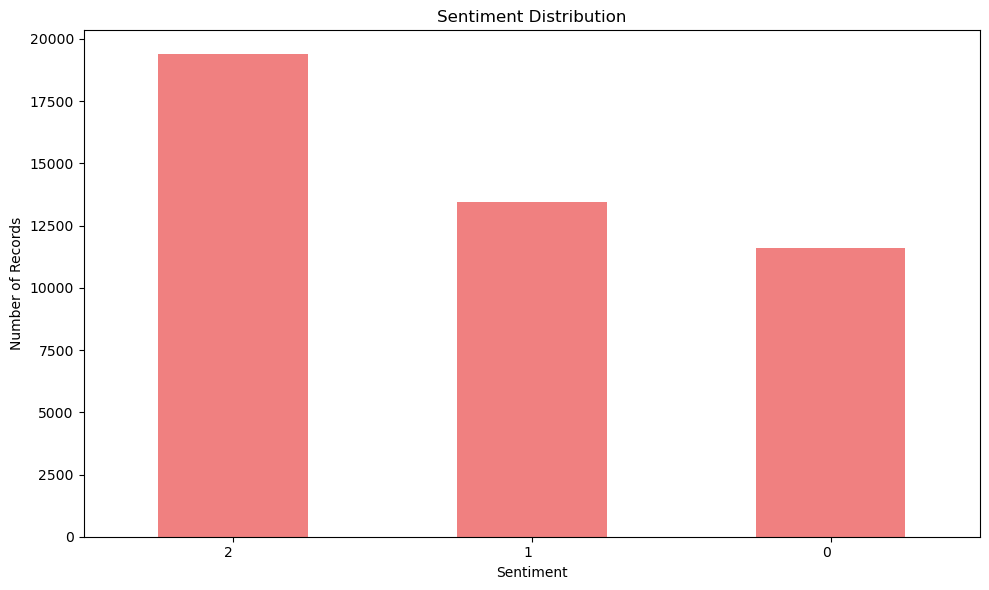

=== Sentiment Ratios ===
sentiment
2    0.436186
1    0.302458
0    0.261356
Name: count, dtype: float64

=== Sentiment Counts ===
sentiment
2    19378
1    13437
0    11611
Name: count, dtype: int64


In [6]:
# For Stock DataFrame
stock_counts, stock_ratios = plot_distribution(
    df=stock_df, 
    label_column='Stock Name', 
    title_prefix='Company',
    color='skyblue'
)

# For Sentiment DataFrame
sentiment_counts, sentiment_ratios = plot_distribution(
    df=sentiment_df, 
    label_column='sentiment', 
    title_prefix='Sentiment',
    color='lightcoral'
)

In [7]:
def get_balanced_subset(df_name: pd.DataFrame, df_column_name: str, num: int, random_state: int = 42) -> pd.DataFrame:
    """
    Returns a roughly balanced subset of size `num` from the given DataFrame.
    
    Parameters
    ----------
    df_name : pd.DataFrame
        The input dataset.
    df_column_name : str
        The name of the column containing class labels.
    num : int
        The total number of samples desired.
    random_state : int, optional
        Random seed for reproducibility (default=42).
    
    Returns
    -------
    pd.DataFrame
        A subset of the original DataFrame with roughly balanced class distribution.
    """
    # Unique classes and samples per class
    classes = df_name[df_column_name].unique()
    samples_per_class = num // len(classes)
    
    balanced_subset = []
    
    for c in classes:
        class_subset = df_name[df_name[df_column_name] == c]
        
        # Sample from each class
        subset = resample(class_subset,
                          replace=False,
                          n_samples=min(len(class_subset), samples_per_class),
                          random_state=random_state)
        balanced_subset.append(subset)
    
    # Combine and shuffle
    balanced_df = pd.concat(balanced_subset)
    balanced_df = balanced_df.sample(frac=1, random_state=random_state).reset_index(drop=True)
    
    return balanced_df

In [8]:
stock_df_balanced = get_balanced_subset(df_name=stock_df, df_column_name='Stock Name', num=sentiment_df.shape[0])
sentiment_df_balanced = get_balanced_subset(df_name=sentiment_df, df_column_name='sentiment', num=stock_df_balanced.shape[0])

In [9]:
print(stock_df_balanced.shape[0])
print(sentiment_df_balanced.shape[0])

23008
23007


## Preprocessing

In [10]:
from TweetNormalizer import normalizeTweet

Clean DFs by removing not required classes

In [11]:
# =========================================
# STOCK_DF PROCESSING
# =========================================

# 1. Create a unique pair identifier combining Stock Name and Company Name
stock_df_processed = stock_df_balanced.copy()
stock_df_processed["pair"] = stock_df_processed["Stock Name"] + "___" + stock_df_processed["Company Name"]

# 2. Map each unique pair to an integer
pair_to_id = {pair: idx for idx, pair in enumerate(stock_df_processed["pair"].unique())}

# 3. Create the numeric 'label' column
stock_df_processed["label_clas"] = stock_df_processed["pair"].map(pair_to_id)

# 4. Drop temporary and unnecessary columns
columns_to_drop = ["pair", "Stock Name", "Date", "Company Name"]
stock_df_processed.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# 5. Rename 'Tweet' column to 'text' to match sentiment_df
stock_df_processed.rename(columns={"Tweet": "text"}, inplace=True)
stock_df_processed["text"] = stock_df_processed["text"].astype(str)

# 6. Normalize text
stock_df_processed["text"] = stock_df_processed["text"].apply(normalizeTweet)

# 7. Inspect
print("Stock DataFrame Head after processing:")
print(stock_df_processed.head())
print("\nFinal Columns in stock_df_processed:")
print(stock_df_processed.columns)


# =========================================
# SENTIMENT_DF PROCESSING
# =========================================

sentiment_df_processed = sentiment_df_balanced.copy()

# 1. Rename columns to match stock_df
sentiment_df_processed.rename(columns={"description": "text", "sentiment": "label_sen"}, inplace=True)
sentiment_df_processed["text"] = sentiment_df_processed["text"].astype(str)

# 2. Normalize text
sentiment_df_processed["text"] = sentiment_df_processed["text"].apply(normalizeTweet)

# 3. Inspect
print("\nSentiment DataFrame Head after processing:")
print(sentiment_df_processed.head())
print("\nFinal Columns in sentiment_df_processed:")
print(sentiment_df_processed.columns)


Stock DataFrame Head after processing:
                                                text  label_clas
0  $ NFLX succeeded in underperforming $ PLTR . T...           0
1  When you buy $ 10,000 of $ QQQ here 's how muc...           1
2  This thing is $ AAPL earnings report away from...           2
3  Nancy Pelosi bought $ 1.7 m - $ 3.5 m of $ CRM...           3
4                    $ NFLX I like this flow HTTPURL           0

Final Columns in stock_df_processed:
Index(['text', 'label_clas'], dtype='object')

Sentiment DataFrame Head after processing:
                                                text  label_sen
0  #0X0 I believe that was your chance to buy the...          1
1  $ SOL I 'm long and strong ( and a bit levered...          2
2  #Ethereum / $ ETH Every major run up has minor...          1
3  $ ARBI vs $ OP is n't even close in terms of a...          1
4  gm - time to bring back #FF Trading & TA @USER...          1

Final Columns in sentiment_df_processed:
Index(['text', 'l

From the below graph we can see that the data is very skewed

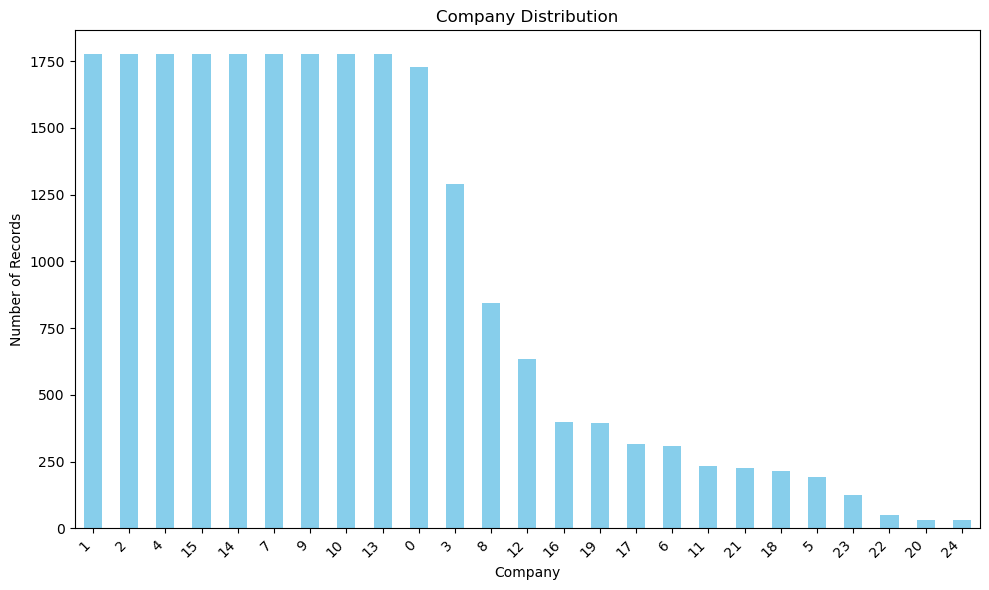

=== Company Ratios ===
label_clas
1     0.077234
2     0.077234
4     0.077234
15    0.077234
14    0.077234
7     0.077234
9     0.077234
10    0.077234
13    0.077234
0     0.075061
3     0.056111
8     0.036639
12    0.027599
16    0.017342
19    0.017081
17    0.013691
6     0.013474
11    0.010127
21    0.009779
18    0.009388
5     0.008388
23    0.005346
22    0.002173
20    0.001347
24    0.001347
Name: count, dtype: float64

=== Company Counts ===
label_clas
1     1777
2     1777
4     1777
15    1777
14    1777
7     1777
9     1777
10    1777
13    1777
0     1727
3     1291
8      843
12     635
16     399
19     393
17     315
6      310
11     233
21     225
18     216
5      193
23     123
22      50
20      31
24      31
Name: count, dtype: int64


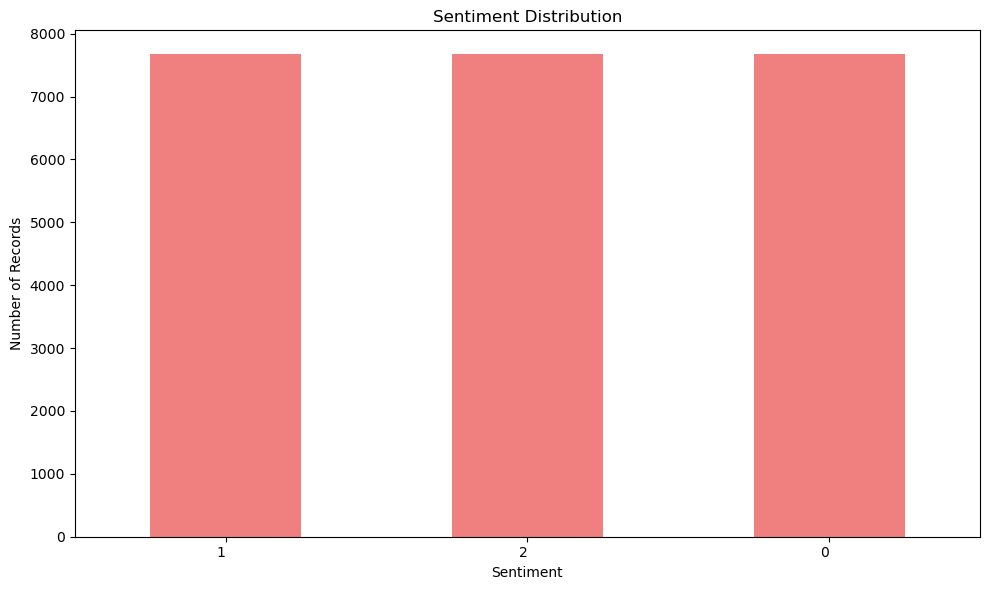

=== Sentiment Ratios ===
label_sen
1    0.333333
2    0.333333
0    0.333333
Name: count, dtype: float64

=== Sentiment Counts ===
label_sen
1    7669
2    7669
0    7669
Name: count, dtype: int64


In [12]:
# For Stock DataFrame
stock_counts, stock_ratios = plot_distribution(
    df=stock_df_processed, 
    label_column='label_clas', 
    title_prefix='Company',
    color='skyblue'
)

# For Sentiment DataFrame
sentiment_counts, sentiment_ratios = plot_distribution(
    df=sentiment_df_processed, 
    label_column='label_sen', 
    title_prefix='Sentiment',
    color='lightcoral'
)

In [13]:
# def make_balanced_sampler(df, label_col="label"):
#     # Count the number of samples per class
#     class_counts = df[label_col].value_counts().sort_index().tolist()
#     num_classes = len(class_counts)

#     # Compute weights for each class (inverse frequency)
#     class_weights = [1.0 / count for count in class_counts]

#     # Assign a weight to each sample in the dataset
#     sample_weights = [class_weights[label] for label in df[label_col]]

#     # Create a sampler
#     sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
#     return sampler
    
# def make_balanced_sampler(df, label_col="label"):
#     """
#     Creates a weighted sampler to balance classes in a dataset.
#     """
#     # Map labels to indices
#     labels = sorted(df[label_col].unique())
#     label_to_idx = {label: i for i, label in enumerate(labels)}
    
#     # Count the number of samples per class
#     class_counts = df[label_col].value_counts().sort_index().tolist()
    
#     # Compute class weights (inverse frequency)
#     class_weights = [1.0 / count for count in class_counts]
    
#     # Assign weight to each sample
#     sample_weights = [class_weights[label_to_idx[label]] for label in df[label_col]]
    
#     sampler = WeightedRandomSampler(
#         weights=sample_weights, 
#         num_samples=len(sample_weights), 
#         replacement=True
#     )
#     return sampler

def load_custom_dataframe(df, tokenizer, max_length=None):
    """
    Converts a DataFrame into a HuggingFace Dataset and tokenizes text.
    Expects df to have columns: 'text', 'label_clas', 'label_sen'
    """
    dataset = Dataset.from_pandas(df)

    if max_length is None:
        max_length = tokenizer.model_max_length
        if max_length <= 0 or max_length > 1e5:
            max_length = 512  # fallback

    def preprocess_function(examples):
        tokenized = tokenizer(
            examples["text"], truncation=True, max_length=max_length
        )
        # Add labels for multi-task
        tokenized["label_clas"] = examples["label_clas"]
        tokenized["label_sen"] = examples["label_sen"]
        return tokenized

    tokenized_dataset = dataset.map(preprocess_function, batched=True)
    return tokenized_dataset

def get_collator(tokenizer):
    """Returns a collator for padding batches"""
    return DataCollatorWithPadding(tokenizer=tokenizer)

def get_multi_task_loaders(train_df, val_df, test_df, batch_size, model_name, use_weighted_sampler=False):
    """
    Returns train, val, test DataLoaders for multi-task setup with:
    - Weighted sampling for balancing classes
    - Randomized order within batches
    """
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    # Convert DataFrames to HuggingFace Datasets
    train_dataset = load_custom_dataframe(train_df, tokenizer)
    val_dataset   = load_custom_dataframe(val_df, tokenizer)
    test_dataset  = load_custom_dataframe(test_df, tokenizer)
    
    # Data collator
    data_collator = get_collator(tokenizer)
    
    # Set PyTorch format
    for ds in [train_dataset, val_dataset, test_dataset]:
        ds.set_format("torch", columns=["input_ids", "attention_mask", "label_clas", "label_sen"])
    
    # Create sampler with both weighting and randomness
    train_sampler = None
    if use_weighted_sampler:
        # Get sample weights
        labels = sorted(train_df['label_clas'].unique())
        label_to_idx = {label: i for i, label in enumerate(labels)}
        class_counts = train_df['label_clas'].value_counts().sort_index().tolist()
        class_weights = [1.0 / count for count in class_counts]
        sample_weights = np.array([class_weights[label_to_idx[label]] for label in train_df['label_clas']])
        
        # Shuffle indices and apply weighted probabilities
        indices = np.arange(len(train_dataset))
        probabilities = sample_weights / sample_weights.sum()
        shuffled_indices = np.random.choice(indices, size=len(indices), replace=True, p=probabilities)
        train_sampler = SubsetRandomSampler(shuffled_indices)
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        sampler=train_sampler, 
        shuffle=True,  # shuffle if no sampler
        collate_fn=data_collator
    )
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        collate_fn=data_collator
    )
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        collate_fn=data_collator
    )
    
    return train_loader, val_loader, test_loader

In [14]:
from sklearn.model_selection import train_test_split

def create_small_dataset(df, sample_frac=0.1, val_frac=0.1, test_frac=0.1, random_state=42):
    """
    Splits a dataset into train, validation, and test sets.
    
    Parameters:
    - df : pandas.DataFrame
        The original dataset.
    - sample_frac : float
        Fraction of the dataset to sample for a small dataset.
    - val_frac : float
        Fraction of the dataset to use as validation (from the sampled data).
    - test_frac : float
        Fraction of the dataset to use as test (from the sampled data).
    - random_state : int
        Seed for reproducibility.
        
    Returns:
    - train_df, val_df, test_df : pandas.DataFrame
    """
    # Step 1: Sample a smaller subset
    small_df = df.sample(frac=sample_frac, random_state=random_state).reset_index(drop=True)
    
    # Step 2: Split into train+temp and test
    train_temp, test_df = train_test_split(
        small_df, test_size=test_frac, random_state=random_state
    )
    
    # Step 3: Split train_temp into train and validation
    val_relative_frac = val_frac / (1 - test_frac)  # Adjust val fraction relative to remaining data
    train_df, val_df = train_test_split(
        train_temp, test_size=val_relative_frac, random_state=random_state
    )
    
    return train_df.reset_index(drop=True), val_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [15]:
# Step 1: Add missing labels
stock_df_processed['label_sen'] = -10
sentiment_df_processed['label_clas'] = -10

# BASICALLY A TINY DATASET
# Step 2: Split each dataset separately
train_stock, val_stock, test_stock = create_small_dataset(
    stock_df_processed, sample_frac=1.0, val_frac=0.1, test_frac=0.1
)

train_sent, val_sent, test_sent = create_small_dataset(
    sentiment_df_processed, sample_frac=1.0, val_frac=0.1, test_frac=0.1
)

# Step 3: Merge corresponding splits
train_df = pd.concat([train_stock, train_sent], ignore_index=True)
val_df   = pd.concat([val_stock, val_sent], ignore_index=True)
test_df  = pd.concat([test_stock, test_sent], ignore_index=True)

print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))

# Optional: merge all for full dataset (if needed)
super_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
print(super_df.head())

# Step 4: Load tokenizer
model_name = "StephanAkkerman/FinTwitBERT-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name, clean_up_tokenization_spaces=False)

# Step 5: Convert dataframe to dataset
super_dataset = load_custom_dataframe(super_df, tokenizer)
print(super_dataset)

Train size: 36811
Validation size: 4602
Test size: 4602
                                                text  label_clas  label_sen
0  $ AMD #AMD Ugly rejection today . Watching for...          15        -10
1  I mainly trade the same 10 stocks / etfs daily...          15        -10
2  How would you describe your investing style ? ...           6        -10
3                          So much passion . HTTPURL           9        -10
4  BREAKING : BofA Securities analyst John Murphy...           7        -10


Map:   0%|          | 0/46015 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label_clas', 'label_sen', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 46015
})


In [16]:
# Load pretrained sentiment model
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Add a new parallel head for your classification task
company_counts = len(stock_counts)
num_new_classes = company_counts
num_sentiment_classes = 3
# new_head = nn.Linear(model.config.hidden_size, num_new_classes)

class HeadCNN(nn.Module):
    def __init__(self, new_num_classes, in_features=768):
        super().__init__()
        self.fc1 = nn.Linear(in_features, 512)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(512, new_num_classes)
        self.final_act = nn.Identity()

    def forward(self, x):
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        x = self.final_act(x)
        return x  # shape [B, new_num_classes]
        
class FrozenBERTMultiHead(nn.Module):
    def __init__(self, model_name, num_sentiment_classes=num_sentiment_classes, num_new_classes=num_new_classes,freeze_head = False, freeze_param = True):
        super().__init__()
        # Load pretrained sentiment model
        self.bert_model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels = num_sentiment_classes  # change sentiment head output size
        )

        # Freeze BERT parameters
        if freeze_param:
            for param in self.bert_model.bert.parameters():
                param.requires_grad = False

        # Freeze sentiment head optionally
        if freeze_head:
            for param in self.bert_model.classifier.parameters():
                param.requires_grad = False

        # New classification head
        self.new_head = HeadCNN(in_features=self.bert_model.config.hidden_size,
                                new_num_classes=num_new_classes)

    def forward(self, input_ids, attention_mask):
        # Get shared BERT embeddings
        outputs = self.bert_model.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_embedding = outputs.last_hidden_state[:, 0, :]  # [CLS] token

        # Compute logits for both heads
        sentiment_logits = self.bert_model.classifier(cls_embedding)
        clas_logits = self.new_head(cls_embedding)

        return sentiment_logits, clas_logits

In [17]:
# def multiclass_dice_loss(pred, target, smooth=1):
#     """
#     Computes Dice Loss for multi-class segmentation.
#     Args:
#         pred: Tensor of predictions (batch_size, C, H, W).
#         target: One-hot encoded ground truth (batch_size, C, H, W).
#         smooth: Smoothing factor.
#     Returns:
#         Scalar Dice Loss.
#     """
#     pred = F.softmax(pred, dim=1)  # Convert logits to probabilities
#     num_classes = pred.shape[1]  # Number of classes (C)
#     dice = 0  # Initialize Dice loss accumulator
    
#     for c in range(num_classes):  # Loop through each class
#         pred_c = pred[:, c]  # Predictions for class c
#         target_c = target[:, c]  # Ground truth for class c
        
#         intersection = (pred_c * target_c).sum(dim=(1, 2))  # Element-wise multiplication
#         union = pred_c.sum(dim=(1, 2)) + target_c.sum(dim=(1, 2))  # Sum of all pixels
        
#         dice += (2. * intersection + smooth) / (union + smooth)  # Per-class Dice score

#     return 1 - dice.mean() / num_classes  # Average Dice Loss across classes
    
# class DualTaskConsistencyLoss(nn.Module):
#     """
#     Implements the multi-task semi-supervised loss described in Section 3.3:
#         L = L_GT + λ * L_semi
#     where:
#         L_GT = supervised loss for both tasks (Eq. 1)
#         L_semi = L_semi_u + L_semi_l (Eq. 2)
#     """

#     def __init__(self, lambda_weight=1.0,ignore_index=-10):
#         super(DualTaskConsistencyLoss, self).__init__()
#         self.lambda_weight = lambda_weight
#         self.ce_loss = nn.CrossEntropyLoss(ignore_index=ignore_index)
#         self.kl_loss = nn.KLDivLoss(reduction="batchmean")

#     def forward(self, outputs_L, outputs_R, labels_1, labels_2):
#          """
#          outputs_L = output from model L: out_L_Clas and out_L_Sen or L_1 and L_2
#          outputs_B = output from model B
#          Need ot find out output's shape <Do not remove this comment>
#          labels_1 = Label for Classification task

#          L^A_1 where Model Left, Dataset A, Task 1
#          Where Dataset A has labels for Classification
#          Task 1 is Classification
#          """
        
#         mask_A = labels_1 != -10 # Showing classification labels
#         mask_B = labels_2 != -10 # Showing sentiment labels

#         Y_1_A = labels_1[mask_A] # Dataset A
#         Y_2_B = labels_A[mask_B] # Dataset B

#         L_1_A = L_1[mask_A] # Supervised(?) prediction
#         R_1_A = R_1[mask_A] # Supervised(?) prediction
#         L_2_B = L_2[mask_B] # Supervised(?) prediction
#         R_2_B = R_2[mask_B] # Supervised(?) prediction

#         L_2_A = L_2[mask_A] # Shows prediction for Task 2
#         R_2_A = R_2[mask_A] # Shows prediction for Task 2
#         L_1_B = L_1[mask_B] # Shows prediction for Task 1
#         R_1_B = R_1[mask_B] # Shows prediction for Task 1

#         outputs_A_clas = outputs_L[mask] # with GT for Classification
#         outputs_A_sent = outputs_L[~mask] # with GT for Sentiment

#         outputs_B_clas = outputs_R[mask] # with GT for Classification
#         outputs_B_sent = outputs_R[~mask] # with GT for Sentiment

#         # ==========================================================
#         # 1. Supervised Loss L^GT  (Eq. 1)
#         # ==========================================================
#         # Only for elements with GT
#         L_GT = self.ce_loss(L_1_A, Y_1_A) + 
#                  self.ce_loss(R_1_A, Y_1_A) +
#                  self.ce_loss(L_2_B, Y_2_B) + 
#                  self.ce_loss(R_2_B, Y_2_B)

#         # ==========================================================
#         # 2. Unlabeled Consistency Loss L^semi_u  (Eq. 2)
#         # ==========================================================
#         L_semi_u = self.kl_loss(
#             F.log_softmax(L_2_A, dim=1),
#             F.log_softmax(R_2_A, dim=1),log_target= True
#         ) + F.kl_loss(
#             F.log_softmax(R_2_A, dim=1),
#             F.log_softmax(L_2_A, dim=1),log_target= True
#         ) +
#          self.kl_loss(
#             F.log_softmax(L_1_B, dim=1),
#             F.log_softmax(R_1_B, dim=1),log_target= True
#         ) + F.kl_loss(
#             F.log_softmax(R_1_B, dim=1),
#             F.log_softmax(L_1_B, dim=1),log_target= True
#         )

#         # ==========================================================
#         # 3. Labeled Consistency Loss L^semi_l
#         # ==========================================================
#         L_semi_l = self.ce_loss(L_1_A, R_1_A) + 
#                  self.ce_loss(R_1_A, L_1_A) +
#                  self.ce_loss(L_2_B, R_2_B) + 
#                  self.ce_loss(R_2_B, L_2_B)

#         # ==========================================================
#         # 4. Combine semi-supervised terms
#         # ==========================================================
#         L_semi = L_semi_u + L_semi_l

#         # ==========================================================
#         # 5. Final total loss (Eq. 3)
#         # ==========================================================
#         total_loss = L_GT + self.lambda_weight * L_semi

#         return total_loss, {
#             "L_total": total_loss.item(),
#             "L_GT": L_GT.item(),
#             "L_semi_u": L_semi_u.item(),
#             "L_semi_l": L_semi_l.item(),
#             "L_semi": L_semi.item()
#         }

In [18]:
class DualTaskConsistencyLoss(nn.Module):
    """
    Multi-task semi-supervised consistency loss:
        L = L_GT + λ * L_semi
    Maintains masking structure for labeled and unlabeled data.
    """

    def __init__(self, lambda_weight=1.0, ignore_index=-10):
        super().__init__()
        self.lambda_weight = lambda_weight
        self.ignore_index = ignore_index
        self.ce_loss = nn.CrossEntropyLoss(ignore_index=ignore_index)
        self.kl_loss = nn.KLDivLoss(reduction="batchmean", log_target=True)

    def forward(self, out_A_sen, out_A_clas, out_B_sen, out_B_clas, labels_clas, labels_sen):
        # print("Shapes of tensors:")
        # print("out_A_sen:", out_A_sen.shape)
        # print("out_A_clas:", out_A_clas.shape)
        # print("out_B_sen:", out_B_sen.shape)
        # print("out_B_clas:", out_B_clas.shape)
        # print("labels_clas:", labels_clas.shape)
        # print("labels_sen:", labels_sen.shape)
        # print("Classification labels min/max:", labels_clas.min().item(), labels_clas.max().item())
        # print("Sentiment labels min/max:", labels_sen.min().item(), labels_sen.max().item())

        # -----------------------------
        # 1. Rename tensors for masking logic
        # -----------------------------
        L_1, L_2 = out_A_clas, out_A_sen  # Model A predictions
        R_1, R_2 = out_B_clas, out_B_sen  # Model B predictions

        # -----------------------------
        # 2. Masks for valid labels
        # -----------------------------
        mask_A = labels_clas != self.ignore_index  # Classification labels
        mask_B = labels_sen != self.ignore_index   # Sentiment labels

        Y_1_A = labels_clas[mask_A]  # Ground truth classification
        Y_2_B = labels_sen[mask_B]   # Ground truth sentiment

        # -----------------------------
        # 3. Apply masks to predictions
        # -----------------------------
        L_1_A = L_1[mask_A]
        R_1_A = R_1[mask_A]
        L_2_B = L_2[mask_B]
        R_2_B = R_2[mask_B]

        # Predictions for consistency loss
        L_2_A = L_2[mask_A]
        R_2_A = R_2[mask_A]
        L_1_B = L_1[mask_B]
        R_1_B = R_1[mask_B]

        # Optional: task-specific outputs (if needed)
        outputs_A_clas = L_1_A
        outputs_A_sent = L_2_B
        outputs_B_clas = R_1_A
        outputs_B_sent = R_2_B

        # -----------------------------
        # 4. Supervised Loss L_GT
        # -----------------------------
        L_GT = 0
        if mask_A.any():
            L_GT += self.ce_loss(L_1_A, Y_1_A)
            L_GT += self.ce_loss(R_1_A, Y_1_A)
        if mask_B.any():
            L_GT += self.ce_loss(L_2_B, Y_2_B)
            L_GT += self.ce_loss(R_2_B, Y_2_B)

        # -----------------------------
        # 5. Unlabeled consistency loss L_semi_u (KL divergence)
        # -----------------------------
        L_semi_u = 0
        if mask_A.any():
            log_L2A = F.log_softmax(L_2_A, dim=1)
            log_R2A = F.log_softmax(R_2_A, dim=1)
            L_semi_u += self.kl_loss(log_L2A, log_R2A)
            L_semi_u += self.kl_loss(log_R2A, log_L2A)
        if mask_B.any():
            log_L1B = F.log_softmax(L_1_B, dim=1)
            log_R1B = F.log_softmax(R_1_B, dim=1)
            L_semi_u += self.kl_loss(log_L1B, log_R1B)
            L_semi_u += self.kl_loss(log_R1B, log_L1B)

        # -----------------------------
        # 6. Labeled consistency loss L_semi_l (optional)
        # -----------------------------
        L_semi_l = 0
        if mask_A.any():
            L_semi_l += self.ce_loss(L_1_A, R_1_A.argmax(dim=1))
            L_semi_l += self.ce_loss(R_1_A, L_1_A.argmax(dim=1))
        if mask_B.any():
            L_semi_l += self.ce_loss(L_2_B, R_2_B.argmax(dim=1))
            L_semi_l += self.ce_loss(R_2_B, L_2_B.argmax(dim=1))

        # -----------------------------
        # 7. Total semi-supervised loss
        # -----------------------------
        L_semi = L_semi_u + L_semi_l

        # -----------------------------
        # 8. Total loss
        # -----------------------------
        total_loss = L_GT + self.lambda_weight * L_semi

        logs = {
            "L_total": total_loss.item(),
            "L_GT": L_GT.item(),
            "L_semi_u": L_semi_u.item(),
            "L_semi_l": L_semi_l.item(),
            "L_semi": L_semi.item()
        }

        return total_loss, logs

In [19]:
import torch
import torch.nn.functional as F

class AccumulatingMetric:
    """Accumulate samples of a metric and automatically keep track of the number of samples."""
    def __init__(self):
        self.metric = 0.0
        self.counter = 0

    def add(self, value):
        self.metric += value
        self.counter += 1

    def avg(self):
        return self.metric / self.counter if self.counter > 0 else 0.0


def accuracy(pred, label):
    """Compute accuracy."""
    hard_pred = pred.argmax(1)
    return (hard_pred == label).float().mean().item()


# ===============================================================
#                     TRAINING LOOP
# ===============================================================

def train_epoch(
    model_A, model_B,
    train_loader,
    optimizer_A, optimizer_B,
    scheduler_A, scheduler_B,
    device,
    loss_fn  # your custom loss function (already includes consistency)
):
    """Train one epoch for two models in parallel that supervise each other."""
    model_A.train()
    model_B.train()

    train_loss = AccumulatingMetric()
    acc_A_taskA = AccumulatingMetric()
    acc_A_taskB = AccumulatingMetric()
    acc_B_taskA = AccumulatingMetric()
    acc_B_taskB = AccumulatingMetric()

    # Track individual loss components
    log_L_total = AccumulatingMetric()
    log_L_GT = AccumulatingMetric()
    log_L_semi_u = AccumulatingMetric()
    log_L_semi_l = AccumulatingMetric()
    log_L_semi = AccumulatingMetric()

    for batch in train_loader:
        for key, val in batch.items():
            batch[key] = val.to(device)
        model_A.to(device)
        model_B.to(device)

        # ---- Forward pass for both models ----
        out_A_sen, out_A_clas = model_A(batch["input_ids"], batch["attention_mask"])
        out_B_sen, out_B_clas = model_B(batch["input_ids"], batch["attention_mask"])

        # ---- Compute total loss and logs ----
        total_loss, logs = loss_fn(
            out_A_sen, out_A_clas,
            out_B_sen, out_B_clas,
            batch["label_clas"], batch["label_sen"]
        )

        # ---- Backward passes ----
        optimizer_A.zero_grad()
        optimizer_B.zero_grad()
        total_loss.backward()
        optimizer_A.step()
        optimizer_B.step()
        scheduler_A.step()
        scheduler_B.step()

        # ---- Track metrics ----
        train_loss.add(total_loss.item())
        log_L_total.add(logs["L_total"])
        log_L_GT.add(logs["L_GT"])
        log_L_semi_u.add(logs["L_semi_u"])
        log_L_semi_l.add(logs["L_semi_l"])
        log_L_semi.add(logs["L_semi"])

        # Compute accuracies for both tasks of both models
        mask_clas = batch["label_clas"] != -10
        mask_sen = batch["label_sen"] != -10

        if mask_clas.any():
            acc_A_taskA.add(accuracy(out_A_clas[mask_clas], batch["label_clas"][mask_clas]))
            acc_B_taskA.add(accuracy(out_B_clas[mask_clas], batch["label_clas"][mask_clas]))

        if mask_sen.any():
            acc_A_taskB.add(accuracy(out_A_sen[mask_sen], batch["label_sen"][mask_sen]))
            acc_B_taskB.add(accuracy(out_B_sen[mask_sen], batch["label_sen"][mask_sen]))

    # ---- Return metrics ----
    return {
        "loss": train_loss.avg(),
        "acc_A_taskA": acc_A_taskA.avg(),
        "acc_A_taskB": acc_A_taskB.avg(),
        "acc_B_taskA": acc_B_taskA.avg(),
        "acc_B_taskB": acc_B_taskB.avg(),
        "logs": {
            "L_total": log_L_total.avg(),
            "L_GT": log_L_GT.avg(),
            "L_semi_u": log_L_semi_u.avg(),
            "L_semi_l": log_L_semi_l.avg(),
            "L_semi": log_L_semi.avg()
        }
    }



# ===============================================================
#                     VALIDATION LOOP
# ===============================================================

def validate_epoch(model_A, model_B, val_loader, device, loss_fn, ignore_index=-10):
    """
    Validation for two models supervising each other.
    
    Args:
        model_A, model_B: The two models to validate.
        val_loader: Validation DataLoader.
        device: torch device.
        loss_fn: DualTaskConsistencyLoss instance.
        ignore_index: label to ignore in metrics.
    
    Returns:
        Dictionary of average losses and accuracies.
    """
    model_A.eval()
    model_B.eval()

    # Metric trackers
    val_loss = AccumulatingMetric()
    acc_A_taskA = AccumulatingMetric()
    acc_A_taskB = AccumulatingMetric()
    acc_B_taskA = AccumulatingMetric()
    acc_B_taskB = AccumulatingMetric()

    with torch.no_grad():
        for batch in val_loader:
            # Move batch to device
            for key, val in batch.items():
                batch[key] = val.to(device)
            model_A.to(device)
            model_B.to(device)

            # Forward pass
            out_A_sen, out_A_clas = model_A(batch["input_ids"], batch["attention_mask"])
            out_B_sen, out_B_clas = model_B(batch["input_ids"], batch["attention_mask"])

            # Compute loss
            total_loss, _ = loss_fn(
                out_A_sen, out_A_clas,
                out_B_sen, out_B_clas,
                batch["label_clas"], batch["label_sen"]
            )
            val_loss.add(total_loss.item())

            mask_clas = (batch["label_clas"] != -10)
            mask_sen = (batch["label_sen"] != -10)
            
            # Apply mask safely
            if mask_clas.any():
                filtered_logits = out_A_clas[mask_clas, :]
                filtered_labels = batch["label_clas"][mask_clas]
                acc_A_taskA.add(accuracy(filtered_logits, filtered_labels))
                
                filtered_logits = out_B_clas[mask_clas, :]
                filtered_labels = batch["label_clas"][mask_clas]
                acc_B_taskA.add(accuracy(filtered_logits, filtered_labels))
            
            if mask_sen.any():
                filtered_logits = out_A_sen[mask_sen, :]
                filtered_labels = batch["label_sen"][mask_sen]
                acc_A_taskB.add(accuracy(filtered_logits, filtered_labels))
                
                filtered_logits = out_B_sen[mask_sen, :]
                filtered_labels = batch["label_sen"][mask_sen]
                acc_B_taskB.add(accuracy(filtered_logits, filtered_labels))

    # Return aggregated metrics
    return {
        "loss": val_loss.avg(),
        "acc_A_taskA": acc_A_taskA.avg(),
        "acc_A_taskB": acc_A_taskB.avg(),
        "acc_B_taskA": acc_B_taskA.avg(),
        "acc_B_taskB": acc_B_taskB.avg(),
    }



In [20]:
# def forward_and_accuracy(model, batch, ignore_index=-10):
#     """
#     Forward pass for a multi-task model and computes accuracies.

#     Args:
#         model: The model to run (returns two tensors: sentiment, classification).
#         batch: Dictionary containing 'input_ids', 'attention_mask', 'label_clas', 'label_sen'.
#         ignore_index: Label to ignore in accuracy calculation

#     Returns:
#         Tuple of:
#             - logits_clas: Tensor of classification logits
#             - logits_sen: Tensor of sentiment logits
#             - metrics: Dictionary with 'acc_clas' and 'acc_sen'
#     """
#     # Automatically detect device
#     device = next(model.parameters()).device

#     # Move batch tensors to device
#     for key, val in batch.items():
#         batch[key] = val.to(device)

#     # Forward pass
#     logits_sen, logits_clas = model(batch["input_ids"], batch["attention_mask"])

#     # Create masks to ignore invalid labels
#     mask_clas = batch["label_clas"] != ignore_index
#     mask_sen = batch["label_sen"] != ignore_index

#     # Compute accuracies using your existing function
#     metrics = {}
#     if mask_clas.any():
#         metrics["acc_clas"] = accuracy(logits_clas[mask_clas], batch["label_clas"][mask_clas])
#     else:
#         metrics["acc_clas"] = None

#     if mask_sen.any():
#         metrics["acc_sen"] = accuracy(logits_sen[mask_sen], batch["label_sen"][mask_sen])
#     else:
#         metrics["acc_sen"] = None

#     return logits_clas, logits_sen, metrics


# model = FrozenBERTMultiHead(
#     model_name=model_name,
#     num_sentiment_classes=num_sentiment_classes,
#     num_new_classes=num_new_classes,
#     freeze_head=False,
#     freeze_param=True
# )

# # 2️⃣ Move model to device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# # 3️⃣ Get DataLoaders
# batch_size = 8
# train_loader, val_loader, test_loader = get_multi_task_loaders(
#     train_df, val_df, test_df, batch_size, model_name
# )

# # 4️⃣ Run the model on the first 5 training batches
# print("\n🔹 Running model on first 5 training batches...\n")
# for i, batch in enumerate(train_loader):
#     # Move batch to device
#     batch = {k: v.to(device) for k, v in batch.items()}
    
#     # Forward pass
#     logits_clas, logits_sen, metrics = forward_and_accuracy(model, batch)
    
#     # Predictions
#     pred_clas = torch.argmax(logits_clas, dim=1)
#     pred_sen  = torch.argmax(logits_sen, dim=1)
    
#     print(f"Batch {i+1}:")
#     print("True label_clas:", batch["label_clas"].cpu().tolist())
#     print("Pred label_clas:", pred_clas.cpu().tolist())
#     print("True label_sen :", batch["label_sen"].cpu().tolist())
#     print("Pred label_sen :", pred_sen.cpu().tolist())
#     print("Metrics:", metrics)
#     print("-" * 60)
    
#     if i == 4:  # stop after 5 batches
#         break




In [21]:
def init_head_weights(module):
    """Initialize only Linear layers"""
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
            nn.init.zeros_(module.bias)

In [22]:
# ===============================================================
#                TRAINING CONFIGURATION
# ===============================================================
lr_sentiment = 1e-5  # slow learning rate for sentiment head
lr_class     = 5e-4  # aggressive learning rate for classification head

# 2️⃣ Get DataLoaders
batch_size = 16
train_loader, val_loader, test_loader = get_multi_task_loaders(
    train_df, val_df, test_df, batch_size, model_name
)
num_epochs = (
    5  # Change this to train for more epochs, we trained our model for 5 epochs
)

steps_per_epoch = len(train_loader)  # number of batches in one epoch
lr_warmup = int(steps_per_epoch * num_epochs * 0.1)  # 10% of total training steps

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 1️⃣ Initialize models
model_A = FrozenBERTMultiHead(
    model_name=model_name,
    num_sentiment_classes=num_sentiment_classes,
    num_new_classes=num_new_classes,
    freeze_head=False,
    freeze_param=True
)
model_B = FrozenBERTMultiHead(
    model_name=model_name,
    num_sentiment_classes=num_sentiment_classes,
    num_new_classes=num_new_classes,
    freeze_head=False,
    freeze_param=True
)

torch.manual_seed(42)
model_A.new_head.apply(init_head_weights)  # Classification head of model A

torch.manual_seed(1234)
model_B.new_head.apply(init_head_weights)  # Classification head of model B



# Model A optimizer
optimizer_A = torch.optim.Adam([
    {'params': model_A.bert_model.classifier.parameters(), 'lr': lr_sentiment},
    {'params': model_A.new_head.parameters(), 'lr': lr_class},
])

# Model B optimizer
optimizer_B = torch.optim.Adam([
    {'params': model_B.bert_model.classifier.parameters(), 'lr': lr_sentiment},
    {'params': model_B.new_head.parameters(), 'lr': lr_class},
])

scheduler_A = torch.optim.lr_scheduler.LambdaLR(
    optimizer_A,
    lambda step: min(step / (lr_warmup / batch_size), 1.0)
)

scheduler_B = torch.optim.lr_scheduler.LambdaLR(
    optimizer_B,
    lambda step: min(step / (lr_warmup / batch_size), 1.0)
)

# 4️⃣ Define your custom dual-task loss function
# This should return (total_loss, logs)
loss_fn = DualTaskConsistencyLoss()

# 5️⃣ Training Loop
best_val_loss = float("inf")

# Lists to store metrics per epoch
train_metrics_list = []
val_metrics_list = []

for epoch in range(num_epochs):
    print(f"\n================ Epoch {epoch+1}/{num_epochs} ================\n")

    # ---- TRAIN ----
    train_metrics = train_epoch(
        model_A, model_B,
        train_loader,
        optimizer_A, optimizer_B,
        scheduler_A, scheduler_B,
        device,
        loss_fn
    )

    # ---- VALIDATE ----
    val_metrics = validate_epoch(
        model_A, model_B,
        val_loader,
        device,
        loss_fn
    )

    # ---- LOG METRICS ----
    print(f"Train Loss: {train_metrics['loss']:.4f} | Val Loss: {val_metrics['loss']:.4f}")
    print(
        f"L[TaskA]: {val_metrics['acc_A_taskA']:.3f}, "
        f"L[TaskB]: {val_metrics['acc_A_taskB']:.3f}, "
        f"R[TaskA]: {val_metrics['acc_B_taskA']:.3f}, "
        f"R[TaskB]: {val_metrics['acc_B_taskB']:.3f}"
    )

    # ---- SAVE BEST MODEL ----
    if val_metrics["loss"] < best_val_loss:
        best_val_loss = val_metrics["loss"]
        torch.save(model_A.state_dict(), "best_model_A.pt")
        torch.save(model_B.state_dict(), "best_model_B.pt")
        print("✅ Saved best models!")

    # ---- STORE METRICS ----
    train_metrics_list.append(train_metrics)
    val_metrics_list.append(val_metrics)

print("\nTraining complete! 🎉")

Map:   0%|          | 0/36811 [00:00<?, ? examples/s]

Map:   0%|          | 0/4602 [00:00<?, ? examples/s]

Map:   0%|          | 0/4602 [00:00<?, ? examples/s]

Using device: cuda

================ Epoch 1/5 ================



C:\Users\adhish\.conda\envs\dml\Lib\site-packages\transformers\models\bert\modeling_bert.py:412: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Train Loss: 9.8807 | Val Loss: 3.6281
L[TaskA]: 0.460, L[TaskB]: 0.563, R[TaskA]: 0.455, R[TaskB]: 0.565
✅ Saved best models!

================ Epoch 2/5 ================

Train Loss: 7.9609 | Val Loss: 3.2725
L[TaskA]: 0.508, L[TaskB]: 0.682, R[TaskA]: 0.508, R[TaskB]: 0.681
✅ Saved best models!

================ Epoch 3/5 ================

Train Loss: 7.4190 | Val Loss: 3.1194
L[TaskA]: 0.523, L[TaskB]: 0.701, R[TaskA]: 0.522, R[TaskB]: 0.701
✅ Saved best models!

================ Epoch 4/5 ================



KeyboardInterrupt: 

In [ ]:
num_epochs = len(train_metrics)

# Extract metrics
train_loss_list = [m['loss'] for m in train_metrics_list]
val_loss_list = [m['loss'] for m in val_metrics_list]

acc_A_taskA_list = [m['acc_A_taskA'] for m in val_metrics_list]
acc_A_taskB_list = [m['acc_A_taskB'] for m in val_metrics_list]
acc_B_taskA_list = [m['acc_B_taskA'] for m in val_metrics_list]
acc_B_taskB_list = [m['acc_B_taskB'] for m in val_metrics_list]

# ---- Plot Train & Val Loss ----
plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), train_loss_list, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs+1), val_metrics, label='Val Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# ---- Plot Validation Accuracy ----
plt.figure(figsize=(10,5))
plt.plot(range(1, num_epochs+1), acc_A_taskA_list, label='A TaskA', marker='o')
plt.plot(range(1, num_epochs+1), acc_A_taskB_list, label='A TaskB', marker='o')
plt.plot(range(1, num_epochs+1), acc_B_taskA_list, label='B TaskA', marker='o')
plt.plot(range(1, num_epochs+1), acc_B_taskB_list, label='B TaskB', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracies per Epoch')
plt.legend()
plt.grid(True)
plt.show()